# RESNET 18

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as vF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from torchvision.models import mobilenet_v2, mobilenet_v3_large, vgg19, vgg16, resnet50, resnet18
from timm.models.swin_transformer import SwinTransformer
from sklearn.linear_model import LinearRegression
import kagglehub
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from losses import SupConLoss
from torch.nn import TripletMarginLoss
import random
from Utils import GetDataset

c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Hyperparameters
batch_size  = 128
epochs      = 250
lr          = 1e-4
split_ratio = 0.9   # %
device      = "cuda:0"
features_dim = 64

dataset = GetDataset(data_augmentation=False)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

class ResNet18E(nn.Module):
  def __init__(self, device : str = "cpu")->None:
    super(ResNet18E, self).__init__()
    self.backbone = resnet18(pretrained=True)
    self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.backbone.fc    = nn.Identity()
    self.linear = nn.Linear(512, 1)
    self.encoder = nn.Sequential(
      self.backbone,
      self.linear
    ).to(device)

  def forward(self, X):
    return self.encoder(X)
  
model = ResNet18E(device).to(device)

optimizer   = torch.optim.Adam(model.parameters(), lr=lr,)
lossfn      = nn.MSELoss()

training_losses = []
validation_losses = []
r2s = []
for epoch in range(epochs):
  model.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')
  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N = images.shape[0]
    V = images.shape[1]
    images = images.to(device)
    temperatures = temperatures.to(device).squeeze()
    ##
    ##
    ##
    pred  = model(images).squeeze()
    loss  = lossfn(pred, temperatures)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1

    print(f'*', end='')
  print('\n')
  print(f'MSE : {losses / count}')
  print(f'RMSE: {np.sqrt(losses / count)}')
  training_losses.append(losses / count)

  with torch.no_grad():
    losses = 0
    count  = 0
    y_pred = []
    y_test = []
    for images, temperatures in val_loader:
      N = images.shape[0]
      V = images.shape[1]
      images = images.to(device)
      temperatures = temperatures.to(device).squeeze()
      pred = model(images).squeeze()
      loss = lossfn(pred, temperatures)
      losses += loss.cpu().detach().numpy()
      count += 1

      y_pred.append(pred.squeeze().cpu().detach().numpy())
      y_test.append(temperatures.squeeze().cpu().detach().numpy())
      
  y_pred = np.array(y_pred).flatten()
  y_test = np.array(y_test).flatten()

  r2 = r2_score(y_test, y_pred)
  print(f'Validation: MSE : {losses / count}')
  print(f'Validation: RMSE: {np.sqrt(losses / count)}')
  print(f'Validation R2: {r2}')
  validation_losses.append(losses / count)
  r2s.append(r2)

Path to dataset files: C:\Users\tsope\.cache\kagglehub\datasets\juanda220485\synthetic-dataset-of-speckle-images\versions\1


c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


########################################
Epoch: 1
*****

MSE : 4677.7166015625
RMSE: 68.39383452887036
Validation: MSE : 4695.54150390625
Validation: RMSE: 68.5240213640899
Validation R2: -2.665432929992676
########################################
Epoch: 2
*****

MSE : 4578.3640625
RMSE: 67.66360958816784
Validation: MSE : 4422.205078125
Validation: RMSE: 66.4996622406836
Validation R2: -2.4520609378814697
########################################
Epoch: 3
*****

MSE : 4122.416357421875
RMSE: 64.20604611266664
Validation: MSE : 4187.24365234375
Validation: RMSE: 64.70891478261515
Validation R2: -2.2686452865600586
########################################
Epoch: 4
*****

MSE : 4292.507763671875
RMSE: 65.51723257030837
Validation: MSE : 4055.574462890625
Validation: RMSE: 63.683392363241964
Validation R2: -2.1658620834350586
########################################
Epoch: 5
*****

MSE : 4222.243505859375
RMSE: 64.97879273931899
Validation: MSE : 3963.819091796875
Validation: RMSE: 62.9588

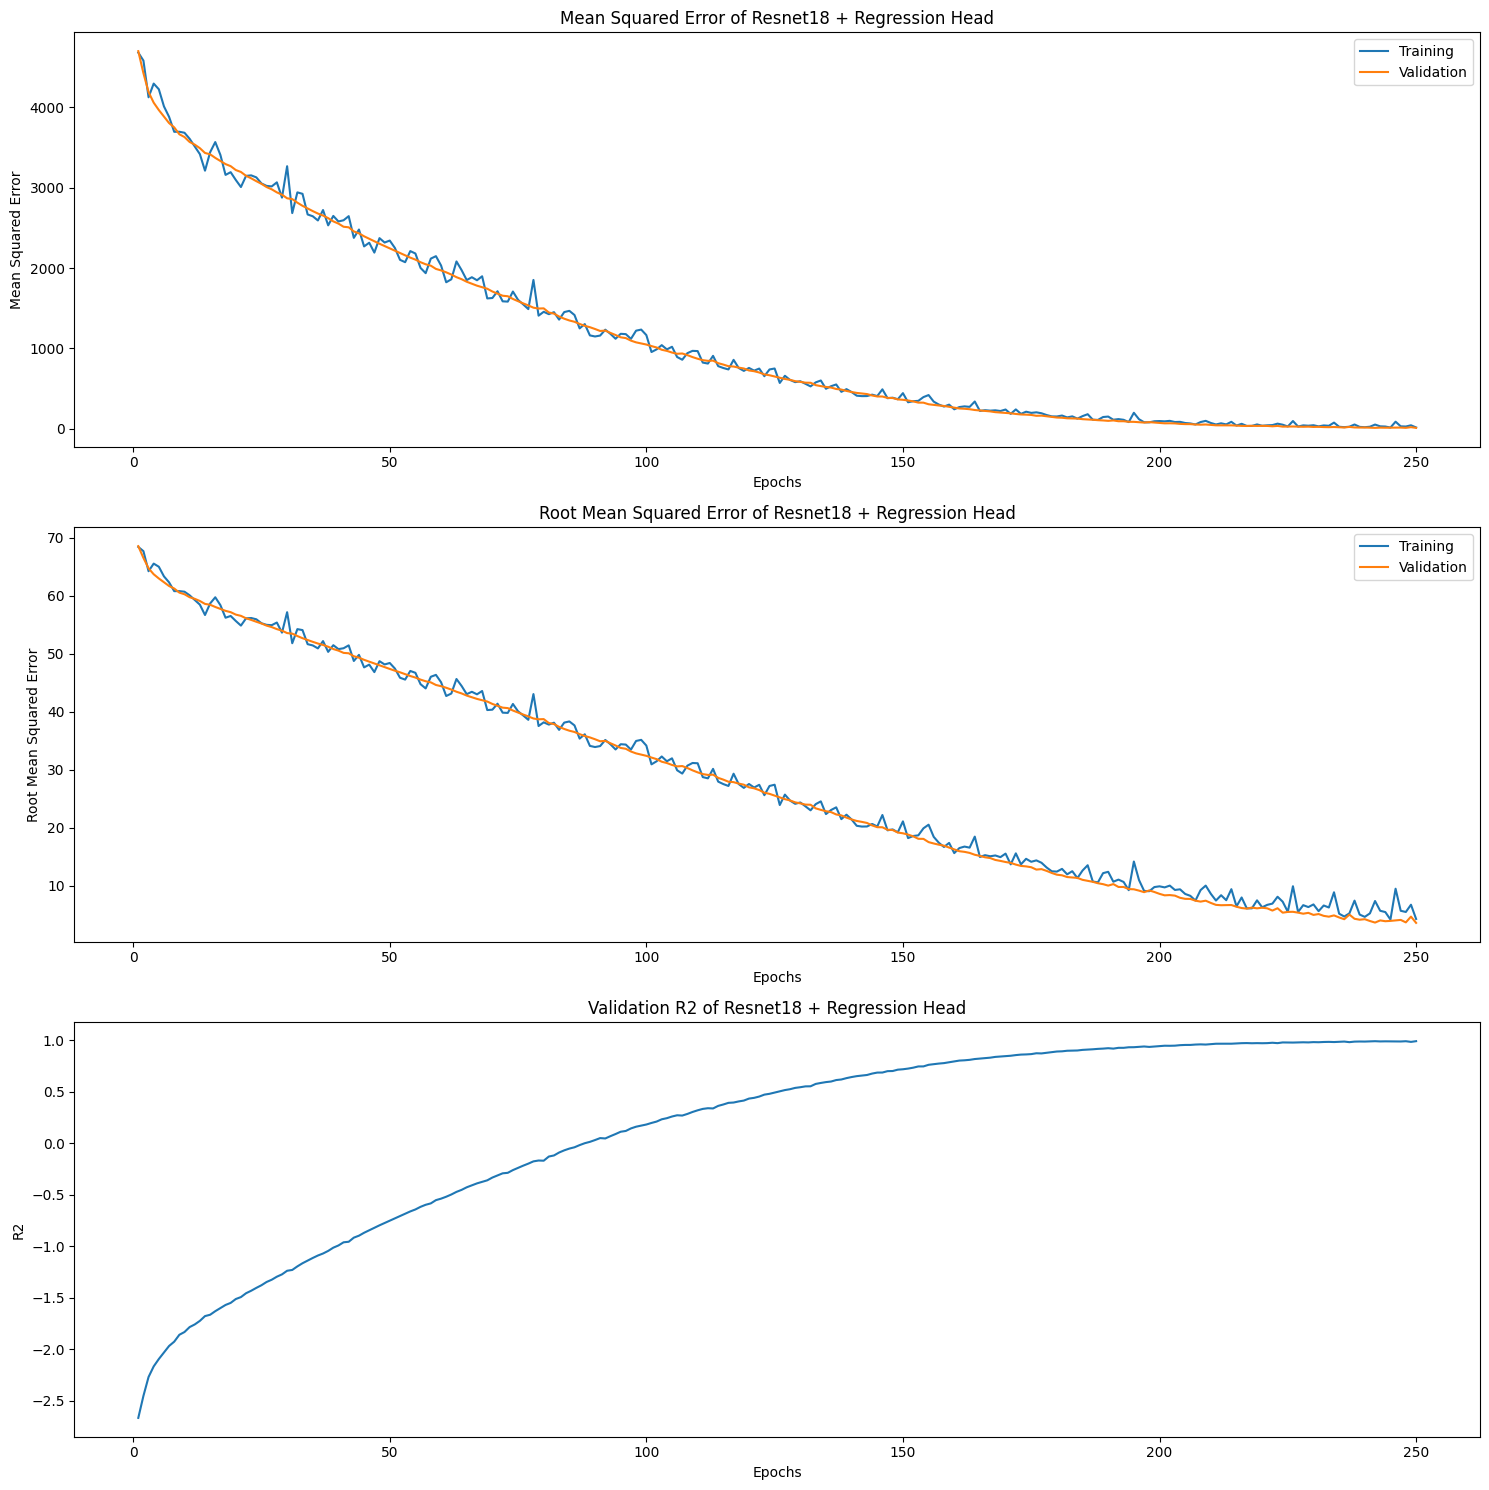

In [4]:
num_epochs_r = np.arange(1, 251)
plt.figure(figsize=[15, 15])
plt.subplot(3, 1, 1)
plt.plot(num_epochs_r, np.array(training_losses), num_epochs_r, np.array(validation_losses))
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error of Resnet18 + Regression Head")
plt.legend(['Training', 'Validation'])

plt.subplot(3, 1, 2)
plt.plot(num_epochs_r, np.sqrt(training_losses), num_epochs_r, np.sqrt(validation_losses))
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.title("Root Mean Squared Error of Resnet18 + Regression Head")
plt.legend(['Training', 'Validation'])

plt.subplot(3, 1, 3)
plt.plot(num_epochs_r, np.array(r2s))
plt.xlabel("Epochs")
plt.ylabel("R2")
plt.title("Validation R2 of Resnet18 + Regression Head")

plt.tight_layout()
plt.show()

In [5]:
torch.save(model, 'resnet18e.pth')

In [6]:
np.save('train_losses.npy', np.array(training_losses))
np.save('val_losses.npy', np.array(validation_losses))
np.save('r2_score.npy', np.array(r2s))